In [1]:
# Import necessary libraries
import cobra
import glob
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import random
import seaborn as sns

from cobra.medium import minimal_medium

input_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/network_files/'
model_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/'
output_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/'
sample_path = '/mnt/Local_Disk_1/Hospital_Microbiome/Data/Output_data/phyloseq_source/'

In [ ]:
# Load all the models
os.chdir(model_path)

# Create an empty DataFrame to store the results
model_info = pd.DataFrame(columns=["Model", "Predicted growth rate", "Number of Genes", "Number of Metabolites", "Number of Reactions"])

# Loop through each SBML file
for models in os.listdir(model_path):
    if models.endswith(".xml"): 
        model = cobra.io.read_sbml_model(models) 
        solution = model.optimize()
        model_info.loc[len(model_info)] = { 
            "Model": models, 
            "Predicted growth rate": solution.objective_value,
            "Number of Genes": len(model.genes),
            "Number of Metabolites": len(model.metabolites),
            "Number of Reactions": len(model.reactions)
        }

model_info.set_index('Model', inplace=True)

# Save the results
model_info.to_csv(output_path + 'model_info.csv', sep = ",", index = True)

model_info

In [2]:
# Generating smetana scores for the communities
environments = ["Hospital", "MetaSUB", "Office"]

# Loading nodes/ interactions informations
nodes_info, edges_info = {}, {}

for env in environments:
    net_edges = pd.read_csv(input_path + env + '_edges.tsv', sep = ",")
    nodes = list(set((list(net_edges['v1']) + list(net_edges['v2']))))
    nodes_info[env] = nodes
    edges_info[env] = net_edges

# Loading abundance information
sample_info = {}

for env in environments:
    sample_info[env] = pd.read_csv(sample_path + env + '_filtered_data.csv', sep = ",")
    sample_info[env].set_index('Species', inplace = True)

sample_info['Hospital'].head()
#edges_info['Hospital'].head()

,MEE001,MEE002,MEE003,MEE004,MEE005,MEE006,MEE007,MEE008,MEE009,MEE010,...,WEE376,WEE377,WEE378,WEE379,WEE380,WEE381,WEE382,WEE384,WEE385,WEE386
Species,,,,,,,,,,,,,,,,,,,,,
Abiotrophia defectiva,0.00000,0.00317,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00000,0.00000,0.17724,0.00000,0.0,0.00578,0.00000,0.00129,0.00777,0.00518
Achromobacter xylosoxidans,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00215,0.0,...,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000
Acinetobacter baumannii,0.00258,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.01955,0.00427,0.01885,0.00785,0.0,0.02886,0.00532,0.00551,0.00291,0.01378
Acinetobacter johnsonii,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00000,0.00000,0.00000,0.00255,0.0,0.00000,0.01293,0.00204,0.00000,0.00000
Acinetobacter junii,0.00281,0.01040,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.00193,0.00000,0.00468,0.00409,0.0,0.00300,0.00311,0.00556,0.00000,0.00400


In [3]:
# Saving network information from the edge file to the networkx graph
network_info = {}

for env in environments:
    G = nx.Graph()

    # Add edges
    for _, row in edges_info[env].iterrows():
        G.add_edge(row['v1'], row['v2'], weight = row['Weight'])
    
    network_info[env] = G
    
# Network details
network_data = pd.DataFrame(columns=["Network", "Number of Nodes", 
                                    "Number of Edges"])

for graph_name, graph in network_info.items():

    # Extract network information
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)

    # Create a DataFrame to store the results
    network_data.loc[len(network_data)] = [graph_name, num_nodes, num_edges]

network_data.set_index('Network', inplace=True)
network_data

,Number of Nodes,Number of Edges
Network,,
Hospital,83,506
MetaSUB,43,97
Office,14,30


In [4]:
# Set a seed for reproducibility
random.seed(42)

# Generate environment-specific communities
def generate_community(graph, env="Hospital", num_nodes=5, num_subgraphs=10, sample_info=sample_info):
    community_df = {"community id": [], "organism id": []}
    communities_generated = 0

    while communities_generated < num_subgraphs:
        node_list = list(graph.nodes())
        nodes = random.sample(node_list, num_nodes)  
        subgraph = graph.subgraph(nodes)  

        if nx.is_connected(subgraph):  
            organism_ids = list(subgraph.nodes())
            sample_subset = sample_info[env].loc[sample_info[env].index.isin(organism_ids)]
            samples = (sample_subset != 0).all()

            if samples.sum() > 0:
                # Generating actual communities
                community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}" 
                for org_id in organism_ids:
                    community_df["community id"].append(community_id)
                    community_df["organism id"].append(org_id)

                # generating random communities with the same number of nodes
                rand_samples = random.choice(list(samples[samples].index))
                rand_sample_subset = sample_info[env][rand_samples]
                rand_organism_ids = random.sample(list(rand_sample_subset[rand_sample_subset != 0].index), k = num_nodes)

                rand_community_id = f"{env}_{num_nodes}_{num_subgraphs}_{communities_generated+1}_random" 
                for rand_org_id in rand_organism_ids:
                    community_df["community id"].append(rand_community_id)
                    community_df["organism id"].append(rand_org_id)
                
                communities_generated += 1
                
                # Plot the subgraph
                #figure = plt.figure(figsize=(5, 5))
                #nx.draw(subgraph, with_labels=True)

    return pd.DataFrame(community_df)

In [19]:
# Simulating communities
com_size = [3, 4, 5]
num_com = [10]

# Overall community information
community_info = pd.DataFrame({"community id": [], "organism id": []})

# Generate communities
for env in environments:
    for size in com_size:
        for num in num_com:
            community_df = generate_community(network_info[env], env=env, num_nodes=size, num_subgraphs=num, sample_info=sample_info)
            community_info = pd.concat([community_info, community_df], ignore_index=True)
            print(f"Number of communities generated for {env} with {size} nodes and {num} communities: {len(community_df)}")
            #community_df.to_csv(output_path + env + f'_communities_{size}_{num}.csv', sep = ",", index = False)

community_info['organism id'] = community_info['organism id'].str.replace(' ', '_')

# Changing the name according to the models
community_info['organism id'] = community_info['organism id'].str.replace('Kocuria_sp._UCD-OTCP', 'Kocuria_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Roseomonas_sp._B5', 'Roseomonas_sp.')
community_info['organism id'] = community_info['organism id'].str.replace('Dermacoccus_sp._Ellin185', 'Dermacoccus_sp.')

# Save the community
community_info.to_csv(output_path + 'community_info.csv', sep = "\t", index = False, header=False)

community_info

Number of communities generated for Hospital with 3 nodes and 10 communities: 60
Number of communities generated for Hospital with 4 nodes and 10 communities: 80
Number of communities generated for Hospital with 5 nodes and 10 communities: 100
Number of communities generated for MetaSUB with 3 nodes and 10 communities: 60
Number of communities generated for MetaSUB with 4 nodes and 10 communities: 80
Number of communities generated for MetaSUB with 5 nodes and 10 communities: 100
Number of communities generated for Office with 3 nodes and 10 communities: 60
Number of communities generated for Office with 4 nodes and 10 communities: 80
Number of communities generated for Office with 5 nodes and 10 communities: 100


,community id,organism id
0,Hospital_3_10_1,Corynebacterium_jeikeium
1,Hospital_3_10_1,Streptococcus_sanguinis
2,Hospital_3_10_1,Limosilactobacillus_fermentum
3,Hospital_3_10_1_random,Actinomyces_oris
4,Hospital_3_10_1_random,Corynebacterium_tuberculostearicum
...,...,...
715,Office_5_10_10_random,Caulobacter_vibrioides
716,Office_5_10_10_random,Methylorubrum_populi
717,Office_5_10_10_random,Methylorubrum_extorquens
718,Office_5_10_10_random,Stutzerimonas_stutzeri


In [20]:
# Check model names
model_files = glob.glob(model_path + '*.xml')
model_files = [os.path.basename(file) for file in model_files]
model_files = [file.replace('.xml', '') for file in model_files]

model_files

mismatch = list(set(list(community_info['organism id'])) - set(model_files))
mismatch

[]

In [25]:
# Write a bash script to run smetana
with open(output_path + 'run_smetana.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Smetana_output/Com_3-4-5_10_v2.csv \\\n")
    f.write("    --solver cplex --flavor bigg --molweight")

In [ ]:
# Write a bash script to run smetana
#with open(output_path + 'run_smetana_minimal.sh', 'w') as f:
#    f.write("#!/bin/bash\n")
#    f.write("smetana /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Models/*.xml \\\n")
#    f.write("    -c /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/community_info.csv \\\n")
#    f.write("    -o /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/Test_Smetana/test_2-5_10_M9.csv \\\n")
#    f.write("    --solver cplex --molweight \\\n")
#    f.write("    -m M9 --mediadb /mnt/Local_Disk_1/Hospital_Microbiome/Data/Modeling/media_db.tsv")

In [26]:
# Run the bash script
!chmod +x {output_path + 'run_smetana.sh'}
!bash {output_path + 'run_smetana.sh'}

/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Enterococcus_faecium
  warn('MRO: Failed to find a valid solution for: ' + org_id)
/home/pratyay/anaconda3/envs/modeling/lib/python3.10/site-packages/smetana/smetana.py:351: UserWarning: MRO: Failed to find a valid solution for: Staphylococcus_capitis
  warn('MRO: Failed to find a valid solution for: ' + org_id)


In [41]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Smetana_output/Com_3-4-5_10_v2.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number', 'Community Type']] = smetana_results['community'].str.split('_', expand = True)

smetana_results['Community Type'] = smetana_results['Community Type'].replace({None: 'real'})
smetana_results

,community,medium,size,mip,mro,Environment,Community Size,Iterations,Community Number,Community Type
0,Hospital_3_10_1,complete,3,5,0.563636,Hospital,3,10,1,real
1,Hospital_3_10_10,complete,3,4,0.660714,Hospital,3,10,10,real
2,Hospital_3_10_10_random,complete,3,4,0.640000,Hospital,3,10,10,random
3,Hospital_3_10_1_random,complete,3,4,0.444444,Hospital,3,10,1,random
4,Hospital_3_10_2,complete,3,6,0.567568,Hospital,3,10,2,real
...,...,...,...,...,...,...,...,...,...,...
175,Office_5_10_7_random,complete,5,4,0.638614,Office,5,10,7,random
176,Office_5_10_8,complete,5,5,0.714286,Office,5,10,8,real
177,Office_5_10_8_random,complete,5,5,0.716216,Office,5,10,8,random
178,Office_5_10_9,complete,5,6,0.660494,Office,5,10,9,real


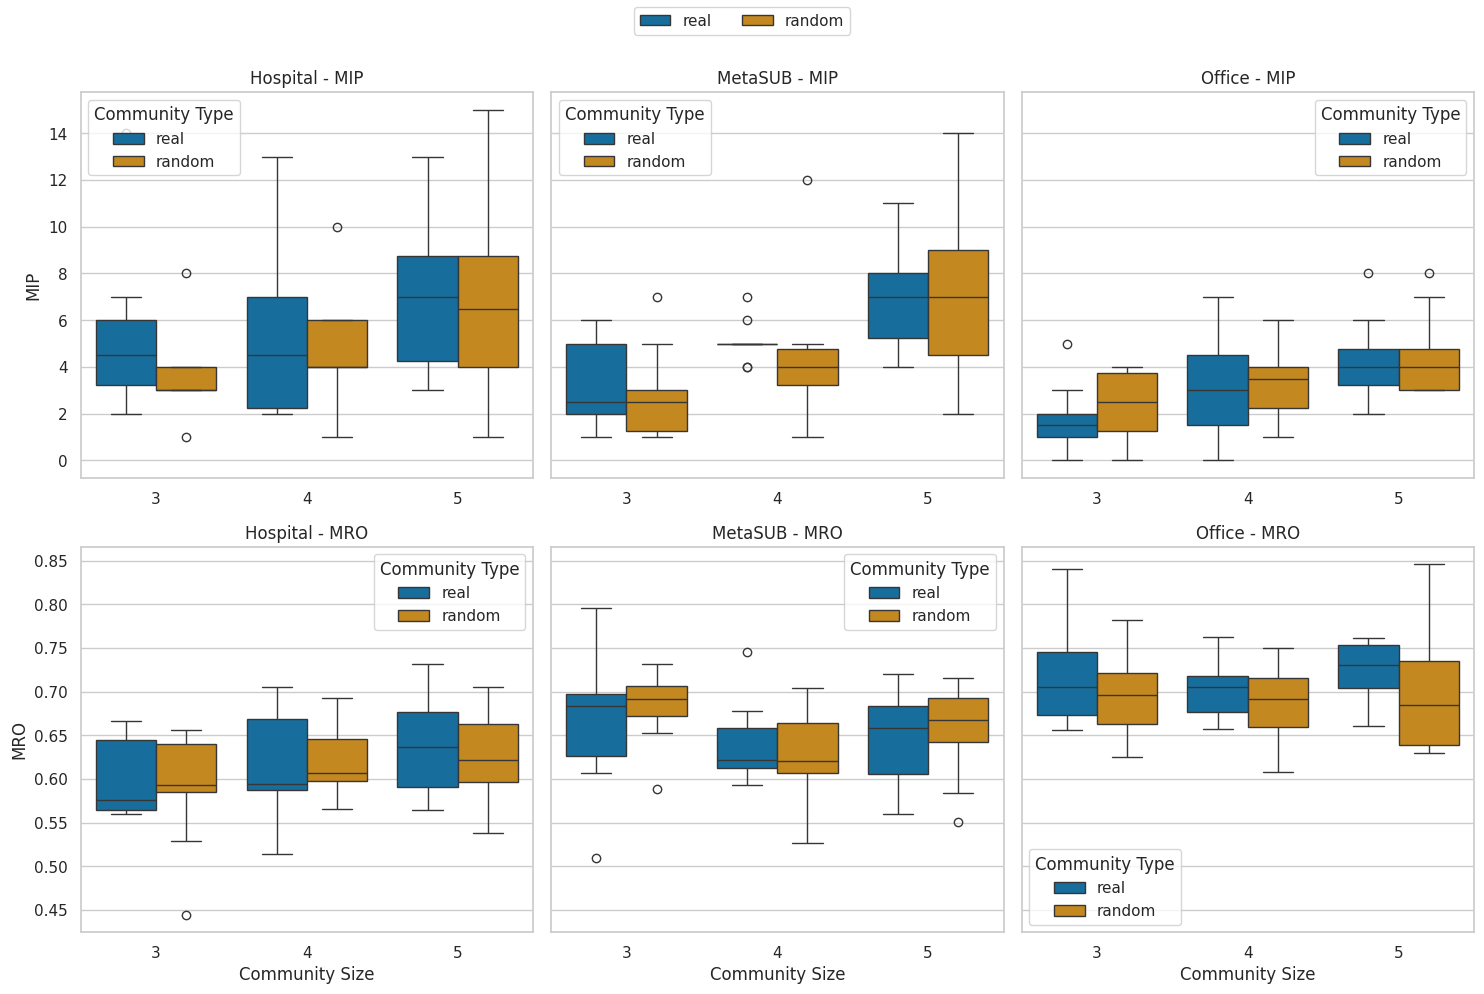

In [42]:
# Create the plot
environments = smetana_results['Environment'].unique()
community_sizes = smetana_results['Community Size'].unique()

n_rows = 2
n_cols = len(environments)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), sharey='row')

for col, environment in enumerate(environments):
    env_data = smetana_results[smetana_results['Environment'] == environment]
    
    # MIP Boxplot
    sns.boxplot(x='Community Size', y='mip', hue='Community Type', data=env_data, ax=axes[0, col], palette="colorblind")
    axes[0, col].set_title(f'{environment} - MIP')
    axes[0, col].set_xlabel('')
    axes[0, col].set_ylabel('MIP')
    
    # MRO Boxplot
    sns.boxplot(x='Community Size', y='mro', hue='Community Type', data=env_data, ax=axes[1, col], palette="colorblind")
    axes[1, col].set_title(f'{environment} - MRO')
    axes[1, col].set_xlabel('Community Size')
    axes[1, col].set_ylabel('MRO')

# Adjust the legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [38]:
smetana_results = smetana_results[smetana_results['Community Type'] == 'random']

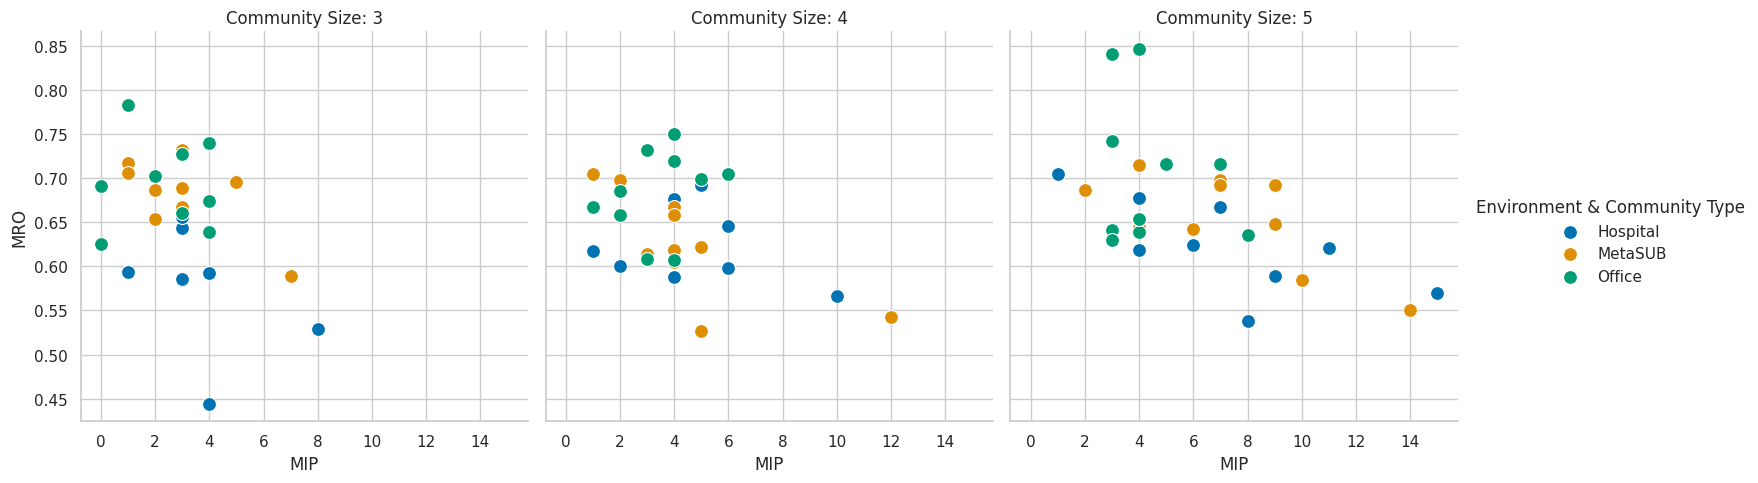

In [39]:
# Create the scatter plot with seaborn
sns.set(style="whitegrid")

# Define the marker styles
markers = {'Real': 'o', 'random': 's'}

# Create a FacetGrid for subplots by 'Community Size'
g = sns.FacetGrid(smetana_results, col="Community Size", hue="Environment", palette="colorblind", 
                  height=5, aspect=1, legend_out=True)

# Map the scatterplot to the grid
g.map(sns.scatterplot, 'mip', 'mro', #style='Community Type', 
      markers=markers, s=100)

# Add axis labels and titles
g.set_axis_labels("MIP", "MRO")
g.add_legend(title="Environment & Community Type")

# Set the titles for each subplot
for ax, title in zip(g.axes.flat, g.col_names):
    ax.set_title(f'Community Size: {title}')

plt.show()

In [ ]:
# plotting

sns.set(style="ticks")

# FacetGrid with subplots based on 'Community Size' and 'Iterations'
g = sns.FacetGrid(smetana_results, col="Community Size", row="Iterations", hue="Environment", margin_titles=True)
g.map(plt.scatter, "mip", "mro", alpha=0.7)

# Adding a legend
g.add_legend()

# Displaying the plots
plt.show()

In [ ]:
sns.set_palette("colorblind")
g = sns.FacetGrid(smetana_results, col="Community Size", row="Iterations", hue="Environment", margin_titles=True,sharex=False, sharey=False)

# Map scatterplot with modified axis
g.map(sns.scatterplot, "mro", "mip", alpha=0.7)

# Adjust the axis based on the values
g.set_axis_labels("mro", "mip")

# Adding a legend
g.add_legend()

# Displaying the plots
plt.show()


In [ ]:

# Visualisation
smetana_results = pd.read_csv(output_path + 'Test_Smetana/test_2-5-8_10-20.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

In [ ]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Test_Smetana/test_2-5_10.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

In [ ]:
# Visualisation
smetana_results = pd.read_csv(output_path + 'Test_Smetana/test_2-5_10.csv_global.tsv', sep = "\t")
smetana_results = smetana_results.dropna()

smetana_results[['Environment', 'Community Size', 'Iterations', 
                 'Community Number']] = smetana_results['community'].str.split('_', expand = True)

smetana_results

In [ ]:
# plotting

sns.set(style="ticks")

# FacetGrid with subplots based on 'Community Size' and 'Iterations'
g = sns.FacetGrid(smetana_results, col="Community Size", row="Iterations", hue="Environment", margin_titles=True)
g.map(plt.scatter, "mip", "mro", alpha=0.7)

# Adding a legend
g.add_legend()

# Displaying the plots
plt.show()

In [ ]:
# Generating minimal media for the communities

model_files = glob.glob(model_path + '*.xml')
minimal_media = {}

for env in environments:
    media = []
    organisms = nodes_info[env]
    organisms = sorted([org.replace(" ", "_") for org in organisms])
    models = [item for item in model_files if any(organism in item for organism in organisms)]
    for model in models:
        model_obj = cobra.io.read_sbml_model(model)
        media += list(minimal_medium(model_obj, 0.1, minimize_components=True).keys())

    media = sorted(list(set([element[3:] for element in media])))
    minimal_media[env] = media

minimal_media